In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Dates

target(x::Float64) = (x^3-15*x^2+7*x+1)/10
target_ravine(p) = sum(p .* p)
target_ravine_2(p) = p[1]^2 + 100*p[2]^2
simplex_test_func(x) = 3*(x[1]-5)^2 + 7*(x[2]-10)^2
fly_func(x) = (x[1]-2*x[2])^2 + (x[2]-9)^2
function target_rastrygin(p)
    A = 10
    result = A*length(p)
    for idx in 1:length(p)
        result += p[idx]^2 - A*cos(2*pi*p[idx])
    end
    return result
end
function target_schefill(p)
    A = 418.9829
    result = A*length(p)
    for idx in 1:length(p)
        result -= p[idx]*sin(sqrt(abs(p[idx])))
    end
    return result
end
target_rosenbrock(p) = (1 - p[1])^2 + 100*(p[2] - p[1]^2)^2


minimumby(f, iter) = reduce(iter) do x, y
    f(x) < f(y) ? x : y
end
minimum_idx_by(f, iter) = reduce(1:length(iter)) do x, y
    f(iter[x]) < f(iter[y]) ? x : y
end

minimum_idx_by (generic function with 1 method)

# DISTANCES

In [2]:
using StatsBase
using Random
using CUDA

function euclid_distance(x, y)
    v = (Float32.(x) - Float32.(y))
    return sqrt(dot(v,v))
end
function boolean_distance(x, y)
    return sum(target .!= x)
end
function hamming_distance(x, y)
    return sum(count_ones.(xor.(x,y)))
end

@enum LossFunctionType EuclidNorm BooleanNorm HammingNorm

struct genetics_function
    dist
    loss
    DIMS
    genetics_function(dist, loss; DIMS=2) = new(dist, loss, DIMS)
end

function create_target_function(target, type = EuclidNorm)
    DIMS = length(target)
    if type == EuclidNorm
        return genetics_function(euclid_distance, x -> euclid_distance(target, x), DIMS=DIMS)
    elseif type == BooleanNorm
        return genetics_function(hamming_distance, x -> hamming_distance(target, x), DIMS=DIMS)
    else
        return genetics_function(boolean_distance, x -> boolean_distance(target, x), DIMS=DIMS)
    end        
end

create_target_function (generic function with 2 methods)

# PARENTS SELECTION

In [3]:
@enum ParentSelectionType Basic Inbreading Outbreading

struct parent_selection{T}
    func::genetics_function
    population
end;

function create_parent_selector(func::genetics_function, selection_type::ParentSelectionType)
    function __selector(population)
        return parent_selection{selection_type}(func, population)
    end
    return __selector
end

function create_basic_parent_selector()
    function __selector(population)
        return parent_selection{Basic}(x->x, population)
    end
    return __selector
end

function Base.iterate(c::parent_selection{Basic}, k=1)
    while k < length(c.population) >> 1
        first_parent_idx = 2*k-1
        second_parent_idx = -1
        k += 1
        while second_parent_idx == -1 || second_parent_idx == first_parent_idx
            second_parent_idx = rand(1:length(c.population))
        end
        return first_parent_idx => second_parent_idx, k
    end
    return nothing, k
end

function Base.iterate(c::parent_selection{Inbreading}, k=1)
    while k < length(c.population) >> 1
        first_parent_idx = rand(1:length(c.population))
        second_parent_idx = minimum_idx_by(x -> c.func.dist(c.population[first_parent_idx], x), c.population)
        k += 1
        return first_parent_idx => second_parent_idx, k
    end
    return nothing
end

function Base.iterate(c::parent_selection{Outbreading}, k=1)
    while k < length(c.population) >> 1
        first_parent_idx = rand(1:length(c.population))
        second_parent_idx = minimum_idx_by(x -> -c.func.dist(c.population[first_parent_idx], x), c.population)
        k += 1
        return first_parent_idx => second_parent_idx, k
    end
    return nothing, nothing
end

function select_parent_pair(c::parent_selection{Basic})
    first_parent_idx = rand(1:length(c.population))
    second_parent_idx = -1
    while second_parent_idx == -1 || second_parent_idx == first_parent_idx
        second_parent_idx = rand(1:length(c.population))
    end
    return first_parent_idx, second_parent_idx
end

function select_parent_pair(c::parent_selection{Inbreading})
    first_parent_idx = rand(1:length(c.population))
    second_parent_idx = minimum_idx_by(x -> c.func.dist(c.population[first_parent_idx], x), c.population)
    return first_parent_idx, second_parent_idx
end

function select_parent_pair(c::parent_selection{Outbreading})
    first_parent_idx = rand(1:length(c.population))
    second_parent_idx = minimum_idx_by(x -> -c.func.dist(c.population[first_parent_idx], x), c.population)
    return first_parent_idx, second_parent_idx
end

Base.length(s::parent_selection{T}) where T = (length(s.population) >> 1 - 1)
Base.firstindex(s::parent_selection{T}) where T = firstindex(s.population)
Base.getindex(s::parent_selection{T}, idx) where T = Base.iterate(s, idx)

In [72]:
f = create_parent_selector(create_target_function([1,1,1]), Basic)
for (a, b) in f([[1,2,3],[4,5,6],[7,8,9]])
    println("$a $b")
end

1 2


# CROSSINGOVERS

In [4]:
@enum CrossType MultiDimOnePoint OnePoint MultiPoint Linear

struct crossover_strategy{T}
    bounds::Tuple{<:Unsigned,<:Unsigned}
    parent_select
    domain::UInt32
    cross_points::UInt32
    function crossover_strategy{T}(bounds, parent_select; domain=1, cross_points=1) where T
        new(bounds, parent_select, domain, cross_points)
    end
end;

function create_crossover_strategy(func::genetics_function, bounds; crossover_type::CrossType=MultiDimOnePoint, selection_type::ParentSelectionType=Basic, domain=1, cross_points=1)
    if crossover_type == OnePoint
        return crossover_strategy{crossover_type}(bounds, create_parent_selector(func, selection_type))
    end    
    return crossover_strategy{crossover_type}(bounds, create_parent_selector(func, selection_type), domain=domain, cross_points=cross_points)
end

function crossover!(generation, s::crossover_strategy{MultiDimOnePoint})
    DIMS = length(generation[1])
    MAX_SHIFT = Base.top_set_bit(max(s.bounds[1], s.bounds[2])) - 1
    @Threads.threads for gen_idx in (length(generation) >> 1)+1:2:length(generation)
        parent_1, parent_2 = select_parent_pair(s.parent_select(generation[1:length(generation) >> 1]))
        for idx in 1:DIMS
            mask_right = (1 << rand(1:MAX_SHIFT)) - 1
            mask_left = ~mask_right
            generation[gen_idx][idx] = clamp((generation[parent_1][idx] & mask_right) | (generation[parent_2][idx] & mask_left), s.bounds[1], s.bounds[2])
            generation[gen_idx+1][idx] = clamp((generation[parent_1][idx] & mask_left) | (generation[parent_2][idx] & mask_right), s.bounds[1], s.bounds[2])
        end
    end
end

function crossover!(generation, s::crossover_strategy{MultiPoint})
    DIMS = length(generation[1])
    TYPE_BIT_SIZE = sizeof(generation[1][1]) << 3
    MAX_SHIFT = DIMS * TYPE_BIT_SIZE
    __shifts = sort(randperm(MAX_SHIFT)[1:s.cross_points])
    @Threads.threads for gen_idx in (length(generation) >> 1)+1:2:length(generation)
        first_parent, second_parent = select_parent_pair(s.parent_select(generation[1:length(generation) >> 1]))
        for shift in __shifts
            shift_dim_idx, shift_bit_index = ceil(Int, shift / TYPE_BIT_SIZE), shift % TYPE_BIT_SIZE
            mask_left = [idx < shift_dim_idx ? typemax(typeof(generation[1][1])) : 0 for idx in 1:DIMS]
            if(shift_bit_index != 0)
                mask_left[shift_dim_idx] = (1 << shift_bit_index) - 1
            end
            mask_right = .~mask_left
            for dim_idx in 1:DIMS
                generation[gen_idx][dim_idx] = (generation[first_parent][dim_idx] & mask_left[dim_idx]) | (generation[second_parent][dim_idx] & mask_right[dim_idx])
                generation[gen_idx+1][dim_idx] = (generation[second_parent][dim_idx] & mask_left[dim_idx]) | (generation[first_parent][dim_idx] & mask_right[dim_idx])
            end            
            first_parent, second_parent = gen_idx, gen_idx+1
        end
    end
end

function crossover!(generation, s::crossover_strategy{Linear})
    @Threads.threads for gen_idx in (length(generation) >> 1) + 1 : length(generation)
        parent_1, parent_2 = select_parent_pair(s.parent_select(generation[1:length(generation) >> 1]))
        alpha = rand(-s.domain:1+s.domain)
        generation[gen_idx] = generation[parent_1] + alpha .* (generation[parent_2] - generation[parent_1])
    end
end

function crossover(population, s::crossover_strategy{Linear}; children_size=1)
    result = [population[0] for i in 1:children_size]
    @Threads.threads for gen_idx in 1:children_size
        parent_1, parent_2 = select_parent_pair(s.parent_select(population[1:length(population) >> 1]))
        alpha = rand(-s.domain:1+s.domain)
        result[gen_idx] = population[parent_1] + alpha .* (population[parent_2] - population[parent_1])
    end
    return result
end

crossover! (generic function with 3 methods)

# MUTATION

In [5]:
@enum MutationType MultiDimOneBit MultiDim OneDim

function mutate!(generation, mutation_type::MutationType; bounds=nothing, mut_prob=0.3)
    DIMS = length(generation[1])
    TYPE_BIT_SIZE = length(generation[1][1]) << 3
    __bounds = (1, typemax(typeof(generation[1][1])))
    if !isnothing(bounds)
        __bounds = bounds
    end
    if mutation_type == MultiDimOnePoint
        Threads.@threads for i in (length(generation) >> 1) + 1:length(generation)
            for j in 1:DIMS
                if rand() < mut_prob
                    generation[i][j] = clamp(xor(population[i][j], 1 << rand(0:TYPE_BIT_SIZE-1)), __bounds...)
                end
            end
        end
    elseif mutation_type == MultiDim
        Threads.@threads for i in (length(generation) >> 1) + 1:length(generation)
            for j in 1:DIMS
                if rand() < mut_prob
                    generation[i][j] = rand(__bounds[1]:__bounds[2])
                end
            end
        end
    else
        Threads.@threads for i in (length(generation) >> 1) + 1:length(generation)
            if rand() < mut_prob
                generation[i][rand(1:DIMS)] = rand(__bounds[1]:__bounds[2])
            end
        end
    end
end

mutate! (generic function with 1 method)

# SELECTION

In [6]:
@enum SelectionType BestHalf Tournament Roullete

function select!(generation, func::genetics_function, selection_type::SelectionType)
    if selection_type == BestHalf
        sort!(generation, by=func.loss)
    elseif selection_type == Roullete
        generation_loss = func.loss.(generation)
        generation_loss_sum = sum(generation_loss)
        for idx in eachindex(generation_loss)
            generation_loss[idx] = generation_loss_sum - generation_loss[idx]
        end
        generation_loss_sum = sum(generation_loss)
        weights = [loss/generation_loss_sum for loss in generation_loss]
        result = sample(generation, Weights(weights), length(generation) >> 1)
        for gen_idx in 1:length(generation)>>1
            generation[gen_idx] = result[gen_idx]
        end
    else
        old_gen = copy(generation)
        for gen_idx in 1:length(generation)>>1
            subset = sample(old_gen, length(generation) >> 1, replace=false)
            generation[gen_idx] = minimum_by(func.loss, subset)
        end
    end
end

select! (generic function with 1 method)

# GENETICS ALGORITHM

In [7]:
function best_gene(generation, func::genetics_function)
    result = nothing
    best_val = typemin(typeof(generation[1][1]))
    for idx in eachindex(generation)
        gene_val = func.loss(generation[idx])
        if best_val < gene_val
            best_val = gene_val
            result = generation[idx]
        end
    end
    return result, best_val
end

struct genetics_strategy
    parent_selection_type::ParentSelectionType
    crossover_type::CrossType
    mutation_type::MutationType
    selection_type::SelectionType
end

function genetics_min(func::genetics_function, bounds::Tuple{<:Unsigned, <:Unsigned}, gen_strategy::genetics_strategy;
                        population_size=10, max_iter=1000, mut_prob=0.3, eps=1e-3, values_type=UInt,
                        domain = 1, cross_points=2,
                        log_every=1, verbose_every=0, slow_mutation_every=300)
    generation = [
        (i <= population_size ?
            [values_type(rand(bounds[1]:bounds[2])) for j in 1:func.DIMS] :
            values_type.(zeros(func.DIMS)))
        for i in 1:population_size<<1
    ]
    cross = create_crossover_strategy(func, bounds,
        crossover_type=gen_strategy.crossover_type, selection_type=gen_strategy.parent_selection_type, domain=domain, cross_points=cross_points)
    iterations = 0
    global_min = generation[1]
    global_min_val = 0
    history = [global_min]
    start = now()
    for idx in 1:max_iter
        iterations += 1
        crossover!(generation, cross)
        mutate!(generation, gen_strategy.mutation_type, bounds=bounds, mut_prob=mut_prob)
        select!(generation, func, gen_strategy.selection_type)
        global_min, global_min_val = best_gene(generation, func)
        if slow_mutation_every > 0 && iterations % slow_mutation_every == 0
            mut_prob /= 2
        end
        if log_every > 0 && iterations % log_every == 0
            push!(history, copy(global_min))
        end
        if verbose_every > 0 && iterations % verbose_every == 0
            current = now()
            println("iteration: $(iterations), best_score: $(global_min_val), elapsed_time: $(current-start)")
            flush(stdout)
            start = current
        end
        if abs(global_min_val) < eps
            break
        end
    end
    return global_min, iterations, history
end

function DLOLinspace(x, src=(1000,10000), dest=(0,1))
    min_src, max_src = min(src...), max(src...)
    src_len = max_src - min_src
    min_dest, max_dest = min(dest...), max(dest...)
    dest_len = max_dest - min_dest
    return dest_len/src_len * (x - min_src) + min_dest
end

function calculate_population_lifespan(func, population, lifespan_bounds)
    min_lifespan, max_lifespan = min(lifespan_bounds...), max(lifespan_bounds...)
    population_fit = func.(population)
    min_fit, max_fit = minimum(population_fit), maximum(population_fit)
    conv(x) = DLOLinspace(x, (min_fit, max_fit), (min_lifespan, max_lifespan))
    return [floor.(Int, conv.(population_fit)) for i in 1:initial_population_size]
end

function GAVaPS(func, bounds::Tuple{<:Unsigned, <:Unsigned}; initial_population_size=100, max_iter=10, mut_prob=0.3, reproduce_prob=0.05, lifespan_bounds=(1,10)
                eps=1e-3, values_type=UInt, log_every=1, verbose_every=0, slow_mutation_every=300)
    min_lifespan, max_lifespan = min(lifespan_bounds...), max(lifespan_bounds...)
    population = [[values_type(rand(bounds[1]:bounds[2])) for j in 1:func.DIMS] for i in 1:initial_population_size]
    population_lifespan = calculate_population_lifespan(func, population, lifespan_bounds)
    aux_population = [[values_type(rand(bounds[1]:bounds[2])) for j in 1:func.DIMS] for i in 1:max(1, floor(Int, initial_population_size * reproduce_prob))]
    cross = crossover_strategy{Linear}(bounds, create_basic_parent_selector(), domain=1)
    iterations = 0
    global_min = generation[1]
    global_min_val = 0
    history = [(population, aux_population)]
    start = now()
    for epoch_idx in 1:max_iter
        for t in 1:max_lifespan
            children_size = max(1, floor(Int, length(population) * reproduce_prob))
            children = crossover(population, s::crossover_strategy{Linear}, children_size=1)
            mutate!(children, MultiDim, bounds=bounds, mut_prob=mut_prob)
            append!(aux_population, children)
            if t >= minimum(population_lifespan)
                pop_buffer, pop_lifespan_buffer = [], []
                mask = t .< population_lifespan
                population = population[mask]
                population_lifespan = population_lifespan[mask]
            end
        end
    end
    return global_min, iterations, history
end

genetics_min (generic function with 1 method)

# IMAGE GENERATION

In [8]:
#import Pkg; Pkg.add("ImageMagick")
using ImageMagick
unpack_val(x) = [x.r.i, x.g.i, x.b.i]

function generate_target_img(size=3)
    result = zeros(UInt8, size^2) .+ 0x6
    for idx in 1:size
        result[trunc(UInt8, size/2)+1 + (idx-1)*size] = 3
        result[(trunc(UInt8, size/2))*size + idx] = 3
        result[(idx-1)*size+idx] = 0
        result[size-idx+1 + (idx-1)*size] = 0
    end
    return result
end

function generate_colored_img(size=3)
    result = zeros(UInt8, (size^2,3)) .+ 0x7
    for idx in 1:size
        result[trunc(UInt8, size/2)+1 + (idx-1)*size,:] = UInt8.(rand(0:7, 3))
        result[(trunc(UInt8, size/2))*size + idx,:] = UInt8.(rand(0:7, 3))
        result[(idx-1)*size+idx,:] = [0x0, 0x0, 0x0]
        result[size-idx+1 + (idx-1)*size,:] = [0x0, 0x0, 0x0]
    end
    return reshape(result, 3*size^2)
end

function read_image(filename="target_image.png")
    target_img = open(filename) do io
        ImageMagick.load(io)
    end
    return reduce(vcat, reshape(unpack_val.(target_img), prod(size(target_img)))), target_img
end

read_image (generic function with 2 methods)

In [9]:
let5_func(x) = 5 - 24*x + 17*(x^2) - (11/3)*(x^3)+(1/4)*(x^4)
result, iter, history = genetics_min(let5_func, [0, 157], population_size=4, max_iter=10)
println("result: $(result), iterations: $(iter)")

LoadError: MethodError: no method matching genetics_min(::typeof(let5_func), ::Vector{Int64}; population_size::Int64, max_iter::Int64)
The function `genetics_min` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  genetics_min([91m::genetics_function[39m, [91m::Tuple{Unsigned, Unsigned}[39m, [91m::genetics_strategy[39m; population_size, max_iter, mut_prob, eps, values_type, domain, cross_points, log_every, verbose_every, slow_mutation_every)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[7]:21[24m[39m


In [ ]:
anim = @animate for idx in 1:length(history)
    plt = Plots.plot(size=(1000, 1000))
    x = -1:0.1:8
    Plots.plot!(plt, x, (x)->let5_func(x), xlims=(-1,8), ylims=(-10,50))
    Plots.plot!(plt, history[idx], (x)->let5_func(x), seriestype=:scatter, color = "blue")
end
gif(anim, "animation.gif", fps=2)

In [ ]:
let5_func_2(x) = (x-1)*(x-3)*(x-4)^2
result, iter, history = genetics_min(let5_func_2, [3, 10], population_size=4, max_iter=10)
println("result: $(result), iterations: $(iter)")

result: 2, iterations: 10


In [ ]:
anim = @animate for idx in 1:length(history)
    plt = Plots.plot(size=(1000, 1000), title="$(idx)/$(length(history))")
    x = -1:0.1:8
    Plots.plot!(plt, x, (x)->let5_func_2(x), xlims=(-1,8), ylims=(-10,50))
    Plots.plot!(plt, history[idx], (x)->let5_func_2(x), seriestype=:scatter, color = "blue")
end
gif(anim, "animation.gif", fps=2)

In [ ]:
lab_func(x) = (x[1]-1)^2 + (x[2]-1)^2
result, iter, history = genetics_min_2d(lab_func, [0, 8], population_size=4, max_iter=100)
println("result: $(result), iterations: $(iter)")

result: UInt64[0x0000000000000001, 0x0000000000000001], iterations: 100


In [ ]:
anim = @animate for idx in 1:length(history)
    plt = Plots.plot(size=(1000, 1000), title="$(idx)/$(length(history))")
    x = y = -1:0.1:8
    #Plots.plot!(plt, x, (x)->let5_func(x), xlims=(-1,8), ylims=(-10,50))
    Plots.plot!(plt, x, y, (x,y)->lab_func([x,y]), st = :contour, levels=:40)
    Plots.plot!(plt, first.(history[idx]), last.(history[idx]), (x,y) -> lab_func([Float32(x),Float32(y)]), seriestype=:scatter, color = "blue")
end
gif(anim, "lab-animation.gif", fps=10)

In [ ]:
result, iter, history = genetics_min_2d(target_rosenbrock, [0, 8], population_size=4, max_iter=100)
println("result: $(result), iterations: $(iter)")

result: UInt64[0x0000000000000001, 0x0000000000000001], iterations: 100


In [ ]:
anim = @animate for idx in 1:length(history)
    plt = Plots.plot(size=(1000, 1000), title="$(idx)/$(length(history))")
    x = y = -1:0.1:8
    Plots.plot!(plt, x, y, (x,y)->target_rosenbrock([x,y]), st = :contour, levels=:40)
    Plots.plot!(plt, first.(history[idx]), last.(history[idx]), (x,y) -> target_rosenbrock([Float32(x),Float32(y)]), seriestype=:scatter, color = "blue")
end
gif(anim, "lab-animation-rosenbrock.gif", fps=10)

In [ ]:
result, iter, history = genetics_min_2d(target_schefill, [0, 500], population_size=100, max_iter=1000)
println("result: $(result), iterations: $(iter)")

result: UInt64[0x00000000000001a5, 0x00000000000001a5], iterations: 1000


In [ ]:
anim = @animate for idx in 1:length(history)
    plt = Plots.plot(size=(1000, 1000), title="$(idx)/$(length(history))")
    x = y = 0:1:500
    Plots.plot!(plt, x, y, (x,y)->target_schefill([x,y]), st = :contour, levels=:40)
    Plots.plot!(plt, first.(history[idx]), last.(history[idx]), (x,y) -> target_schefill([Float32(x),Float32(y)]), seriestype=:scatter, color = "blue")
end
gif(anim, "lab-animation-rosenbrock.gif", fps=10)

In [ ]:
sizes = [3, 5, 9, 21]
imgs = []
tf = []
for size in sizes
    im = generate_target_img(size)
    push!(imgs, im)
    push!(tf, generate_target_function(im))
end
results = []
for idx in 1:length(tf)
    @time result, iterations, history = genetics_min(tf[idx], [0, 6], population_size=1000, max_iter=500, stop=true, DIMS=sizes[idx]^2, mut_prob=0.2,henocide_after=50, values_type=UInt8)
    push!(results, [result, iterations, history])
    println("size: $(sizes[idx]), iterations: $(iterations), score: $(tf[idx](result))")
    flush(stdout)
end

  0.350772 seconds (4.11 M allocations: 337.683 MiB, 8.00% gc time)
size: 3, iterations: 24, score: 0.0
 11.378278 seconds (93.64 M allocations: 10.744 GiB, 9.86% gc time)
size: 5, iterations: 457, score: 0.0
 26.591622 seconds (159.48 M allocations: 30.260 GiB, 11.59% gc time)
size: 9, iterations: 500, score: 9.848858
119.493661 seconds (515.89 M allocations: 154.630 GiB, 12.59% gc time)
size: 21, iterations: 500, score: 51.739735


In [ ]:
b_tf = []
for im in imgs
    push!(b_tf, generate_target_function(im, BooleanNorm))
end
b_results = []
for idx in 1:length(tf)
    result, iterations, history = genetics_min(b_tf[idx], [0, 6], population_size=1000, max_iter=500, stop=true, DIMS=sizes[idx]^2, mut_prob=0.2, henocide_after=50)
    push!(b_results, [result, iterations, history])
    println("size: $(sizes[idx]), result: $(result), iterations: $(iterations), score: $(b_tf[idx](result))")
end

In [ ]:
sizes = [3, 5, 9, 21]
colored_imgs = []
colored_tf = []
for size in sizes
    im = generate_colored_img(size)
    push!(colored_imgs, im)
    push!(colored_tf, generate_target_function(im))
end
c_results = []
for idx in 1:length(colored_tf)
    @time result, iterations, history = genetics_min(colored_tf[idx], [0, 7], population_size=1000, max_iter=500, stop=true, DIMS=3*sizes[idx]^2, mut_prob=0.01,henocide_after=500, values_type=UInt8)
    push!(c_results, [result, iterations, history])
    println("size: $(sizes[idx]), result: $(result), iterations: $(iterations), score: $(colored_tf[idx](result))")
    flush(stdout)
end

  8.324232 seconds (100.17 M allocations: 12.197 GiB, 3.72% gc time)
size: 3, result: UInt8[0x00, 0x03, 0x00, 0x02, 0x00, 0x06, 0x00, 0x07, 0x00, 0x00, 0x07, 0x00, 0x07, 0x00, 0x01, 0x00, 0x03, 0x00, 0x00, 0x02, 0x00, 0x04, 0x00, 0x01, 0x00, 0x07, 0x00], iterations: 500, score: 1.0
 15.305223 seconds (147.65 M allocations: 25.816 GiB, 6.32% gc time)
size: 5, result: UInt8[0x00, 0x07, 0x00, 0x07, 0x00, 0x07, 0x00, 0x02, 0x00, 0x07, 0x02, 0x06, 0x00, 0x01, 0x06, 0x07, 0x00, 0x05, 0x00, 0x07, 0x00, 0x07, 0x07, 0x07, 0x00, 0x00, 0x07, 0x02, 0x07, 0x00, 0x07, 0x00, 0x00, 0x00, 0x07, 0x00, 0x07, 0x00, 0x02, 0x01, 0x07, 0x00, 0x03, 0x00, 0x07, 0x00, 0x07, 0x00, 0x07, 0x00, 0x00, 0x07, 0x03, 0x07, 0x00, 0x07, 0x00, 0x03, 0x00, 0x07, 0x01, 0x07, 0x00, 0x00, 0x07, 0x07, 0x00, 0x06, 0x00, 0x07, 0x00, 0x07, 0x05, 0x07, 0x00], iterations: 500, score: 1.0
 42.704100 seconds (317.37 M allocations: 80.248 GiB, 7.74% gc time)
size: 9, result: UInt8[0x00, 0x07, 0x07, 0x07, 0x04, 0x07, 0x07, 0x06, 0x00, 

In [ ]:
for sz_idx in 1:length(sizes)
    initial_matrix = reshape(imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx]))
    anim = @animate for idx in 1:length(results[sz_idx][3])
        current_matrix = reshape(results[sz_idx][3][idx], (sizes[sz_idx], sizes[sz_idx]))
        p1 = Plots.heatmap(initial_matrix, c=:grays, title="Начальное изображение", clims=(0,7), colorbar=false)
        p2 = Plots.heatmap(current_matrix, c=:grays, title="$(idx)/$(length(results[sz_idx][3]))\nDist: $(round(results[sz_idx][4][idx][2], digits=2))", clims=(0,7), colorbar=false)
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-img-gen-$(sizes[sz_idx])-ec.gif", fps=10)
end

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-3-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-5-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-9-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-21-ec.gif


In [ ]:
for sz_idx in 1:length(sizes)
    anim = @animate for idx in 1:length(b_results[sz_idx][3])
        current_matrix = reshape(b_results[sz_idx][4][idx][1], (sizes[sz_idx], sizes[sz_idx]))
        initial_matrix = reshape(imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx]))
        p1 = Plots.heatmap(initial_matrix, c=:grays, title="Начальное изображение", clims=(0,7), colorbar=false)
        p2 = Plots.heatmap(current_matrix, c=:grays, title="$(idx)/$(length(b_results[sz_idx][3]))\nBoolDist: $(round(b_results[sz_idx][4][idx][2], digits=2))", clims=(0,7), colorbar=false)
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-img-gen-$(sizes[sz_idx])-bc.gif", fps=10)
end

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-3-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-5-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-9-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-21-bc.gif


In [ ]:
for sz_idx in 1:length(sizes)
    initial_matrix = reshape(imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx], 3))
    initial_colors = [RGB((initial_matrix[i,j,:]/sum(initial_matrix[i,j,:]))...) for i in 1:sizes[sz_idx] for j in 1:sizes[sz_idx]]
    anim = @animate for idx in 1:length(b_results[sz_idx][3])
        current_matrix = reshape(b_results[sz_idx][4][idx][1], (sizes[sz_idx], sizes[sz_idx]))
        p1 = Plots.heatmap(initial_matrix, c=initial_colors, title="Начальное изображение", clims=(0,7), colorbar=false)
        p2 = Plots.heatmap(current_matrix, c=:grays, title="$(idx)/$(length(b_results[sz_idx][3]))\nBoolDist: $(round(b_results[sz_idx][4][idx][2], digits=2))", clims=(0,7), colorbar=false)
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-colimg-gen-$(sizes[sz_idx])-bc.gif", fps=10)
end

In [ ]:
for sz_idx in 1:length(sizes)
    initial_matrix = reshape(colored_imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx], 3))
    initial_colors = [[RGB((initial_matrix[i,j,:]/0x7...)) for i in 1:sizes[sz_idx]] for j in 1:sizes[sz_idx]]
    initial_img = hcat(initial_colors...)
    anim = @animate for idx in 1:length(c_results[sz_idx][3])
        current_matrix =  reshape(c_results[sz_idx][3][idx], (sizes[sz_idx], sizes[sz_idx], 3))
        current_colors = [[RGB((current_matrix[i,j,:]/0x7...)) for i in 1:sizes[sz_idx]] for j in 1:sizes[sz_idx]]
        current_img = hcat(current_colors...)
        p1 = Plots.plot(initial_img, title="Начальное изображение")
        p2 = Plots.plot(current_img, title="$(idx)/$(length(c_results[sz_idx][3]))\nDist: $(colored_tf[sz_idx](c_results[sz_idx][3][idx]))")
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-colimg-gen-$(sizes[sz_idx])-ec.gif", fps=10)
end


[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-3-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-5-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-9-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-21-ec.gif


In [9]:
image_vector, target_img = read_image("target_image.png")
image_tf = create_target_function(image_vector)

genetics_function(Main.euclid_distance, var"#7#10"{Vector{UInt8}}(UInt8[0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff  …  0xff, 0xfe, 0xfe, 0xfe, 0xff, 0xff, 0xff, 0xe9, 0xe9, 0xe9]), 30000)

# Euclid_Basic_MultiDimOnePoint_MultiDimOneBit_BestHalf

In [51]:
strategy = genetics_strategy(Basic, MultiDimOnePoint, MultiDimOneBit, BestHalf)
result, iterations, history = genetics_min(image_tf, (0x00, 0xff), strategy, population_size=500, max_iter=3000, mut_prob=0.01, values_type=UInt8, verbose_every=5, log_every=50)

iteration: 5, best_score: 22927.018, elapsed_time: 4231 milliseconds
iteration: 10, best_score: 22818.39, elapsed_time: 4406 milliseconds
iteration: 15, best_score: 22742.54, elapsed_time: 4388 milliseconds
iteration: 20, best_score: 22678.254, elapsed_time: 4405 milliseconds
iteration: 25, best_score: 22619.412, elapsed_time: 4621 milliseconds
iteration: 30, best_score: 22556.219, elapsed_time: 4407 milliseconds
iteration: 35, best_score: 22495.848, elapsed_time: 4520 milliseconds
iteration: 40, best_score: 22431.492, elapsed_time: 4391 milliseconds
iteration: 45, best_score: 22375.432, elapsed_time: 4564 milliseconds
iteration: 50, best_score: 22320.4, elapsed_time: 4455 milliseconds
iteration: 55, best_score: 22261.287, elapsed_time: 4628 milliseconds
iteration: 60, best_score: 22193.537, elapsed_time: 4472 milliseconds
iteration: 65, best_score: 22137.459, elapsed_time: 4594 milliseconds
iteration: 70, best_score: 22077.662, elapsed_time: 4540 milliseconds
iteration: 75, best_score

(UInt8[0xf2, 0xf3, 0xda, 0x3f, 0xef, 0xf5, 0x78, 0xef, 0xd0, 0xe7  …  0xed, 0x7f, 0x72, 0x9e, 0x3d, 0x3f, 0xe2, 0x28, 0xf6, 0xce], 3000, Vector{UInt8}[[0xf2, 0xf3, 0xda, 0x3f, 0xef, 0xf5, 0x78, 0xef, 0xd0, 0xe7  …  0xed, 0x7f, 0x72, 0x9e, 0x3d, 0x3f, 0xe2, 0x28, 0xf6, 0xce], [0xff, 0x91, 0xc4, 0x0f, 0xd6, 0xdc, 0x1a, 0xd8, 0x90, 0xd0  …  0xfb, 0x50, 0x11, 0x9f, 0x2e, 0x31, 0x83, 0x16, 0xa6, 0xde], [0xe3, 0xc3, 0xf4, 0x05, 0xaf, 0xd8, 0x3d, 0xe3, 0xb1, 0xd5  …  0xe0, 0x65, 0x1a, 0xaf, 0x2e, 0x21, 0x86, 0x2f, 0x82, 0xc0], [0x82, 0xf3, 0xc4, 0x0c, 0xbc, 0xd2, 0x38, 0xe7, 0xc0, 0xc3  …  0xfe, 0x79, 0x2f, 0x9b, 0x35, 0x2d, 0x85, 0x09, 0xf5, 0xc1], [0xc6, 0xb1, 0xd6, 0x1d, 0xcf, 0xe3, 0x39, 0xe7, 0xd1, 0xc6  …  0xfc, 0x36, 0x36, 0x9e, 0x27, 0x2e, 0xc3, 0x08, 0xe2, 0xc5], [0xf2, 0xf1, 0xd2, 0x15, 0xef, 0xdd, 0x38, 0xe5, 0xd4, 0xc7  …  0xd9, 0x6d, 0x7e, 0xba, 0x09, 0x2d, 0xe4, 0x08, 0xfe, 0xc0], [0xd2, 0xf2, 0xdf, 0x1d, 0xee, 0xf6, 0x30, 0xe2, 0xd1, 0xe6  …  0xfd, 0x2d, 0x7f, 0xbf, 0x34, 0x2e,

# Euclid_Basic_MultiPoint_MultiDimOneBit_Roullete

In [ ]:
strategy = genetics_strategy(Basic, MultiPoint, MultiDimOneBit, Roullete)
result, iterations, history = genetics_min(image_tf, (0x00, 0xff), strategy, population_size=500, max_iter=3000, mut_prob=0.01, values_type=UInt8, verbose_every=5, log_every=50)

iteration: 5, best_score: 23128.408, elapsed_time: 5854 milliseconds
iteration: 10, best_score: 23206.432, elapsed_time: 4644 milliseconds
iteration: 15, best_score: 23175.729, elapsed_time: 4609 milliseconds


[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-huge_img-gen-100-ec-bas-mdop-mdob-bh.gif


Plots.AnimatedGif("/home/user/code/BMSTU/Optimizers/lab9/lab-huge_img-gen-100-ec-bas-mdop-mdob-bh.gif")
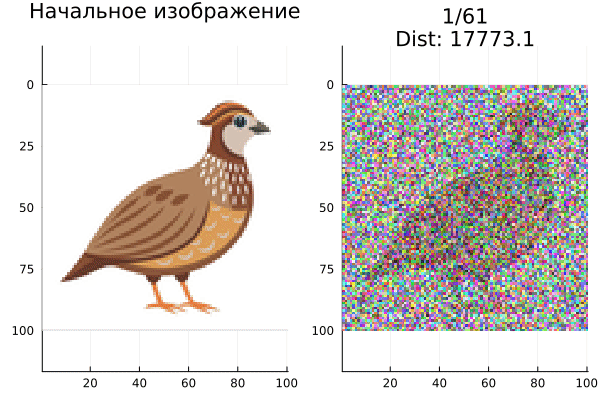

In [59]:
initial_matrix = reshape(image_vector, (3, size(target_img)...))
initial_colors = [[RGB((initial_matrix[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
initial_img = hcat(initial_colors...)
anim = @animate for idx in 1:length(history)
    current_matrix =  reshape(history[idx], (3, size(target_img)...))
    current_colors = [[RGB((current_matrix[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
    current_img = hcat(current_colors...)
    p1 = Plots.plot(initial_img, title="Начальное изображение")
    p2 = Plots.plot(current_img, title="$(idx)/$(length(history))\nDist: $(image_tf.loss(history[idx]))")
    Plots.plot(p1, p2)
end
gif(anim, "lab-huge_img-gen-$(size(target_img)[1])-ec-bas-mdop-mdob-bh.gif", fps=5)

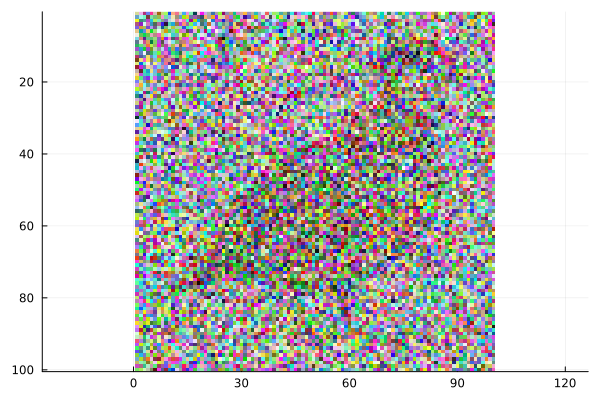

In [ ]:
test = reshape(result, (3,size(target_img)...))
test1 = [[RGB((test[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
test2 = hcat(test1...)
Plots.plot(test2)